# Verification and Hyperparameters

## 1. Metrics
#### Bias
description

$$
Bias = \sum_{n=1}^N   | \hat{y}_n - y_n |
$$

#### RMSE
description
$$
RMSE =\sqrt{ \sum_{n=1}^N  (\hat{y}_n - y_n)^2 }
$$

#### Nash-Sutcliffe-Efficiency

The classical version after Nash and Sutcliffe (1970) compares the squared error of the discharge forecast with the squared error of forecasting the mean discharge:

$$
NSE = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{(y_n - \overline{y})^2} 
$$


#### Alternative Nash-Sutcliffe-Efficiency (for predicting differences)
When we start our prediction at time $t$, we can use the current discharge to predict tomorrow's discharge. This means that we are essentially predicting just differences in discharge.


As we are using this strategy of using the discharge information at forecast init time (=analysis time), we observe another issue related that needs us to change the formulation of the NSE score.

Think of a model that is constantly predicting just the initial discharge value. Such a model can be close to the truth without adding predictive value. In the classical NSE however, such a model would have a high NSE, since the deviations from the truth are small.

Thus, to keep the interpretation of the NSE (comparing to the easiest forecast), we divide by the variance of the error of a persistence forecast ( $ \overline{y} \leftarrow $persistence). This formulation yields a NSE* of 0 when the forecast is just predicting the initial discharge value. The best achievable value is still 1.



## 2. Model evaluation

In [182]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import xarray as xr

import sys
sys.path.append('../../')
from python.aux.plot import plot_recurrent
from python.aux.utils import xr_to_datetime
from python.aux.utils_floodmodel import add_valid_time
from python.aux.verification import ME, RMSE, RMSE_persistence, NSE, NSE_diff

In [ ]:
def verify(prediction, truth):
    """Evaluate multiday forecasts.
    
    As we are dealing with multiday forecasts, 
    we will evaluate each forecast day separately.
    
    Parameters
    ----------
    prediction : xr.DataArray
        2-dimensional discharge forecast (init_time, forecast_day)
        
    truth : xr.DataArray
        1-dimensional discharge (time)
    """
    fcst_days = prediction.forecast_day.values
    
    # allocate to save scores
    N_scores = 5
    scores = np.full((len(fcst_days), N_scores+1,), np.nan)
    
    # separate scores for each forecast day
    for i, day in enumerate(fcst_days):
        print('forecast-day:', day)
        
        # get prediction values for these days (multiple inits)
        pred_fxd = prediction.sel(forecast_day=day)
        
        # get observation values for these days
        valid_time = pred_fxd.init_time + np.timedelta64(day, 'D')
        truth_fxd = truth.sel(time=valid_time)

        scores[i,:] = np.array([day, 
                                ME(pred_fxd, truth_fxd), 
                                RMSE(pred_fxd, truth_fxd), 
                                RMSE_persistence(pred_fxd, truth),
                                NSE(pred_fxd, truth_fxd), 
                                NSE_diff(pred_fxd, truth)])

    df = pd.DataFrame(index=scores[:,0], data=scores[:, 1:], 
                      columns=['ME', 'RMSE', 'RMSE_persistence', 'NSE', 'NSE_diff'])
    df.index.name = 'forecast_day'
    return df

### Load the "truth" (reanalysis) at the test gridpoint

In [177]:
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
dis = glofas['dis']

lat, lon = 48.35, 13.95  # the point where predictions are made
truth = dis.interp(latitude=lat, longitude=lon)

## 2.1 Time-delay neural net predictions

In [181]:
def open_prediction(path):
    """Convenience function"""
    pred = xr.open_dataset(path).to_array().squeeze().drop(['variable', 'name'])
    pred = add_valid_time(pred)
    return pred

model_dir = '../../models/'

In [4]:
model_name = 'tdnn-catchment_mean-differences2'

In [5]:
validation = open_prediction(model_dir+model_name+'/validation.nc')
test = open_prediction(model_dir+model_name+'/test.nc')

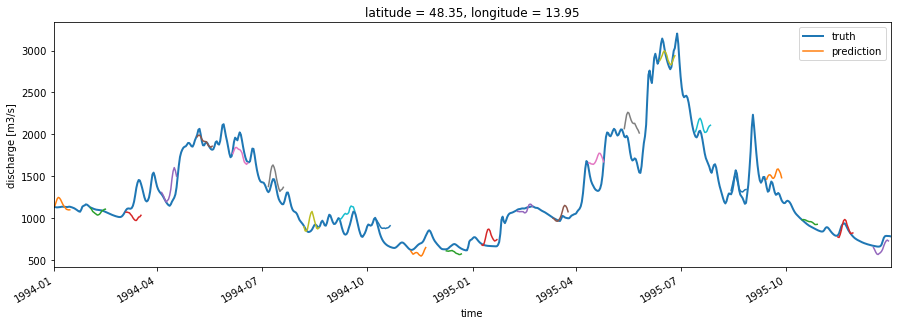

In [6]:
test_time = slice('1994', '1995')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=test_time), 
                   prediction=test, each_N=31)

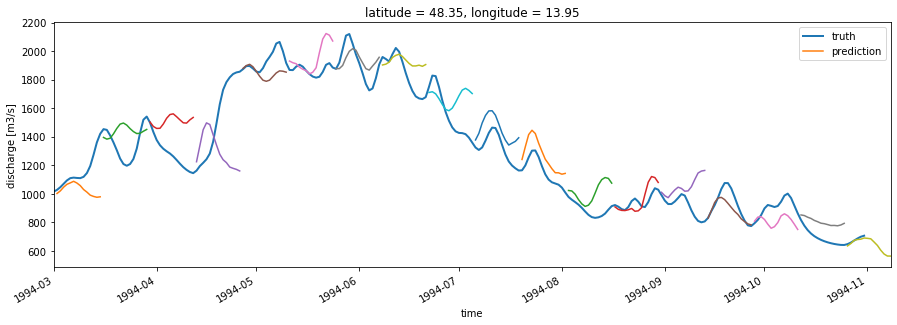

In [7]:
time=slice('1994-03', '1994-10')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=time),
                   prediction=test.sel(init_time=time), each_N=14)

In [ ]:
d = verify(test, truth)

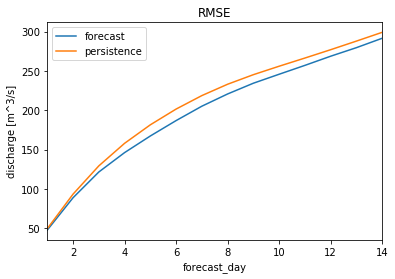

In [172]:
#d = verify(test, truth)
d.RMSE.plot(title='RMSE', label='forecast')
d.RMSE_persistence.plot(label='persistence')
plt.ylabel('discharge [m^3/s]')
plt.legend()

In [173]:
d.ME #.plot(title='Bias')
#plt.ylabel('discharge [m^3/s]')

forecast_day
1.0    -0.060402
2.0    -0.015111
3.0    -0.267536
4.0     0.345409
5.0     0.655129
6.0     1.589019
7.0     2.258566
8.0     2.718315
9.0     3.547504
10.0    3.923509
11.0    4.633873
12.0    5.500652
13.0    5.406063
14.0    5.836487
Name: ME, dtype: float64

Text(0, 0.5, 'NSE [1]')

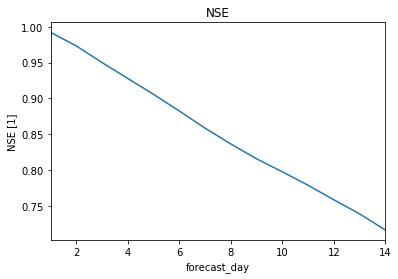

In [168]:
d.NSE.plot(title='NSE')
plt.ylabel('NSE [1]')

Text(0, 0.5, 'NSE [1]')

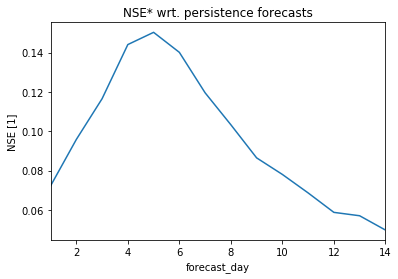

In [175]:
d.NSE_diff.plot(title="NSE* wrt. persistence forecasts")
plt.ylabel('NSE [1]')

## 2.2 Time-convolutional neural net predictions